<a href="https://colab.research.google.com/github/shahin-ro/FashionMNIST-Clustering/blob/main/FashionMNIST_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, silhouette_score

## **Loads the Fashion-MNIST dataset using `fetch_openml`. If an error occurs (e.g., internet issue), it retries with a different dataset name. Data (`X`) is converted to `float32`, labels (`y`) to `int`. It then prints the number of samples (`X.shape[0]`) and pixels (`X.shape[1]`).**

In [ ]:
try:
    fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='liac-arff')
except Exception as e:
    print(f"Error {e}")
    print("please check your internet")
    try:
        fashion_mnist = fetch_openml('fashion_mnist', version=1, as_frame=False, parser='liac-arff')
    except Exception as e:
        print(f"Error{e}")
        print("Failed")
        exit()

X = fashion_mnist.data.astype('float32')
y = fashion_mnist.target.astype('int')

print(X.shape[0])
print(f"Pixel: {X.shape[1]}")

70000
Pixel: 784


### **Sets `n_samples_total` to 5000. If it exceeds the dataset size (`X.shape[0]`), it adjusts to the maximum available samples and prints a message. Splits data into `X_subset` and `y_subset` using `train_test_split` with stratification and a random seed of 42. Prints the number of selected images. Applies `StandardScaler` to standardize `X_subset` into `X_scaled` and returns its shape.**

In [ ]:
n_samples_total = 5000


if n_samples_total > X.shape[0]:
    n_samples_total = X.shape[0]
    print(f"Requested number of samples ({n_samples_total}) is more than total, using {X.shape[0]} samples.")



X_subset, _, y_subset, _ = train_test_split(X, y, train_size=n_samples_total, stratify=y, random_state=42)

print(f"Number of images selected for analysis: {X_subset.shape[0]}")



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

X_scaled.shape

Number of images selected for analysis: 5000


(5000, 784)

## **Sets `n_clusters_kmeans` to 10. Initializes a K-Means model with `k-means++` initialization, 10 initializations (`n_init`), and a random seed of 42. Prints a message indicating K-Means training to find 10 groups. Fits the model to `X_scaled` and predicts cluster labels, storing them in `kmeans_labels`.**

In [ ]:
n_clusters_kmeans = 10

kmeans = KMeans(n_clusters=n_clusters_kmeans, init='k-means++', n_init=10, random_state=42)

print(f"Training K-Means to find {n_clusters_kmeans} groups...")

kmeans_labels = kmeans.fit_predict(X_scaled)

Training K-Means to find 10 groups...


## **Retrieves K-Means cluster centers (`centroids_scaled`). Checks if their dimensions match the scaler's mean. If compatible, inverse-transforms centroids to original scale (`centroids_original_scale`); otherwise, prints an error and sets it to `None`. If `centroids_original_scale` is valid and has 784 dimensions, visualizes each centroid as a 28x28 grayscale image in a 1x10 plot with titles "Group {i}". Adjusts layout and displays the plot. If not, prints an error about non-displayable clusters.**

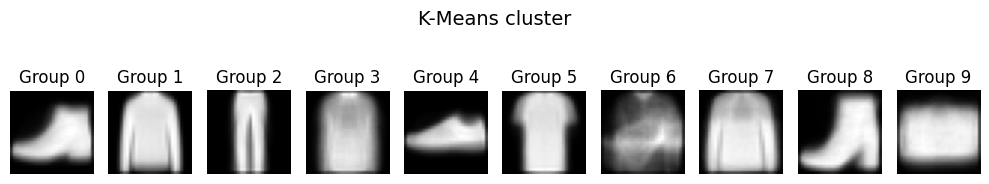

In [ ]:
centroids_scaled = kmeans.cluster_centers_
if centroids_scaled.shape[1] == scaler.mean_.shape[0]:
    centroids_original_scale = scaler.inverse_transform(centroids_scaled)
else:
    print("Error: Centroid dimensions are incompatible with the scaler dimensions. Skipping display.")
    centroids_original_scale = None


if centroids_original_scale is not None and centroids_original_scale.shape[1] == 784:
    fig, axes = plt.subplots(1, n_clusters_kmeans, figsize=(10, 2))
    fig.suptitle("K-Means cluster", fontsize=14)

    for i, ax in enumerate(axes):
        centroid_image = centroids_original_scale[i].reshape(28, 28)
        ax.imshow(centroid_image, cmap='gray')
        ax.set_title(f"Group {i}")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

else:
    print("Cluster representatives are not displayable (dimension or transformation issue).")



## **Sets `n_samples_hierarchical` to 500, adjusting to `X_scaled` size if needed. Sets `n_clusters_agg` to 10. If samples are fewer than clusters, skips clustering, setting variables to `None`. Otherwise, splits 500 samples from `X_scaled` and `y_subset` (stratified, random seed 42), applies Agglomerative Clustering (Ward, Euclidean), and predicts labels. Inverse-transforms subset to original scale, handling errors by using scaled data or setting to `None`.**

In [ ]:
n_samples_hierarchical = 500


if n_samples_hierarchical > X_scaled.shape[0]:
    n_samples_hierarchical = X_scaled.shape[0]

    print(f"Number of available samples ({n_samples_total}) is less than {n_samples_hierarchical}, using {X_scaled.shape[0]} samples.")



n_clusters_agg = 10
if n_samples_hierarchical < n_clusters_agg:
    print(f"Number of samples for hierarchical clustering ({n_samples_hierarchical}) is less than the desired number of groups ({n_clusters_agg}). Hierarchical clustering will not be performed.")
    agg_labels = None
    X_hierarchical_subset = None
    y_hierarchical_subset = None
    X_hierarchical_original_scale = None
else:

    X_hierarchical_subset, _, y_hierarchical_subset, _ = train_test_split(X_scaled, y_subset,
                                               train_size=n_samples_hierarchical,
                                               stratify=y_subset,
                                               random_state=42)

    print(f"Number of images selected for Agglomerative Clustering: {X_hierarchical_subset.shape[0]}")


    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters_agg, linkage='ward', metric='euclidean')

    print(f"Training Agglomerative Clustering to find {n_clusters_agg} groups...")

    agg_labels = agg_cluster.fit_predict(X_hierarchical_subset)




    if scaler is not None and X_hierarchical_subset is not None:
        try:

            X_hierarchical_original_scale = scaler.inverse_transform(X_hierarchical_subset)
        except Exception as e:
             print(f"Error during inverse transformation of hierarchical data for display: {e}")
             X_hierarchical_original_scale = X_hierarchical_subset
    else:
        X_hierarchical_original_scale = None


Number of images selected for Agglomerative Clustering: 500
Training Agglomerative Clustering to find 10 groups...


## **Defines a function `plot_sample_images_from_clusters` to visualize sample images from clusters. Maps Fashion-MNIST labels (e.g., 0: "T-shirt/top"). Checks if input data, labels, and predicted labels are valid and consistent. Creates a grid plot (`n_clusters` x `n_samples_per_cluster`) to display up to 5 images per cluster as 28x28 grayscale images, showing true labels. Handles empty clusters, dimension errors, or index errors by displaying placeholders or error messages. Adjusts layout and shows the plot.**

In [ ]:
def plot_sample_images_from_clusters(X_data, labels, predicted_labels, n_clusters, n_samples_per_cluster=5, title_prefix=""):

    fashion_mnist_labels_map = {
        0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
        5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
    }


    if X_data is None or labels is None or predicted_labels is None:
         print(f"Data for plotting '{title_prefix}' is not available.")
         return

    if not (len(X_data) == len(labels) == len(predicted_labels)):
        print(f"Warning: Dimensions of data ({len(X_data)}), true labels ({len(labels)}), and predicted labels ({len(predicted_labels)}) are inconsistent. Cannot plot images.")
        return


    fig, axes = plt.subplots(n_clusters, n_samples_per_cluster, figsize=(n_samples_per_cluster * 1.5, n_clusters * 1.5))
    fig.suptitle(f"{title_prefix}: Sample Images from Each Group", fontsize=16)



    if n_clusters == 1 and n_samples_per_cluster == 1:
        axes = np.array([[axes]])
    elif n_clusters == 1:
         axes = axes.reshape(1, n_samples_per_cluster)
    elif n_samples_per_cluster == 1:
         axes = axes.reshape(n_clusters, 1)



    for i in range(n_clusters):

        cluster_indices = np.where(predicted_labels == i)[0]

        if len(cluster_indices) == 0:

            for j in range(n_samples_per_cluster):

                if i < axes.shape[0] and j < axes.shape[1]:
                    axes[i, j].imshow(np.zeros((28,28)), cmap='gray')
                    axes[i, j].set_title(f"Group {i}\nempty")
                    axes[i, j].axis('off')
            continue


        num_samples_to_show = min(n_samples_per_cluster, len(cluster_indices))

        selected_indices_in_cluster = np.random.choice(cluster_indices, size=num_samples_to_show, replace=False)


        for j, idx_in_original_subset in enumerate(selected_indices_in_cluster):

            if idx_in_original_subset < len(X_data) and i < axes.shape[0] and j < axes.shape[1]:

                if X_data.shape[1] == 784:
                    image_to_show = X_data[idx_in_original_subset].reshape(28, 28)
                    true_label_numeric = labels[idx_in_original_subset]
                    true_label_text = fashion_mnist_labels_map.get(true_label_numeric, f"Unknown ({true_label_numeric})")

                    axes[i, j].imshow(image_to_show, cmap='gray')
                    axes[i, j].set_title(f"Group: {i}\nReal: {true_label_text}")
                    axes[i, j].axis('off')
                else:

                    axes[i, j].text(0.5, 0.5, 'Dim Error', horizontalalignment='center', verticalalignment='center', transform=axes[i, j].transAxes, color='red')
                    axes[i, j].set_title(f"Group: {i}\n(Dim Error)")
                    axes[i, j].axis('off')

            else:

                 if i < axes.shape[0] and j < axes.shape[1]:
                      axes[i, j].text(0.5, 0.5, 'Index Error', horizontalalignment='center', verticalalignment='center', transform=axes[i, j].transAxes, color='red')
                      axes[i, j].set_title(f"Group: {i}\n(Error)")
                      axes[i, j].axis('off')



        for j_empty in range(num_samples_to_show, n_samples_per_cluster):

            if i < axes.shape[0] and j_empty < axes.shape[1]:
                axes[i, j_empty].imshow(np.zeros((28,28)), cmap='gray')
                axes[i, j_empty].axis('off')


    if 'fig' in locals() and fig is not None:
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## **Calls `plot_sample_images_from_clusters` to visualize up to 5 images per cluster from `X_subset` using `kmeans_labels` for K-Means clustering. Sets title prefix to "K-Means" and displays images with true labels from `y_subset`.**

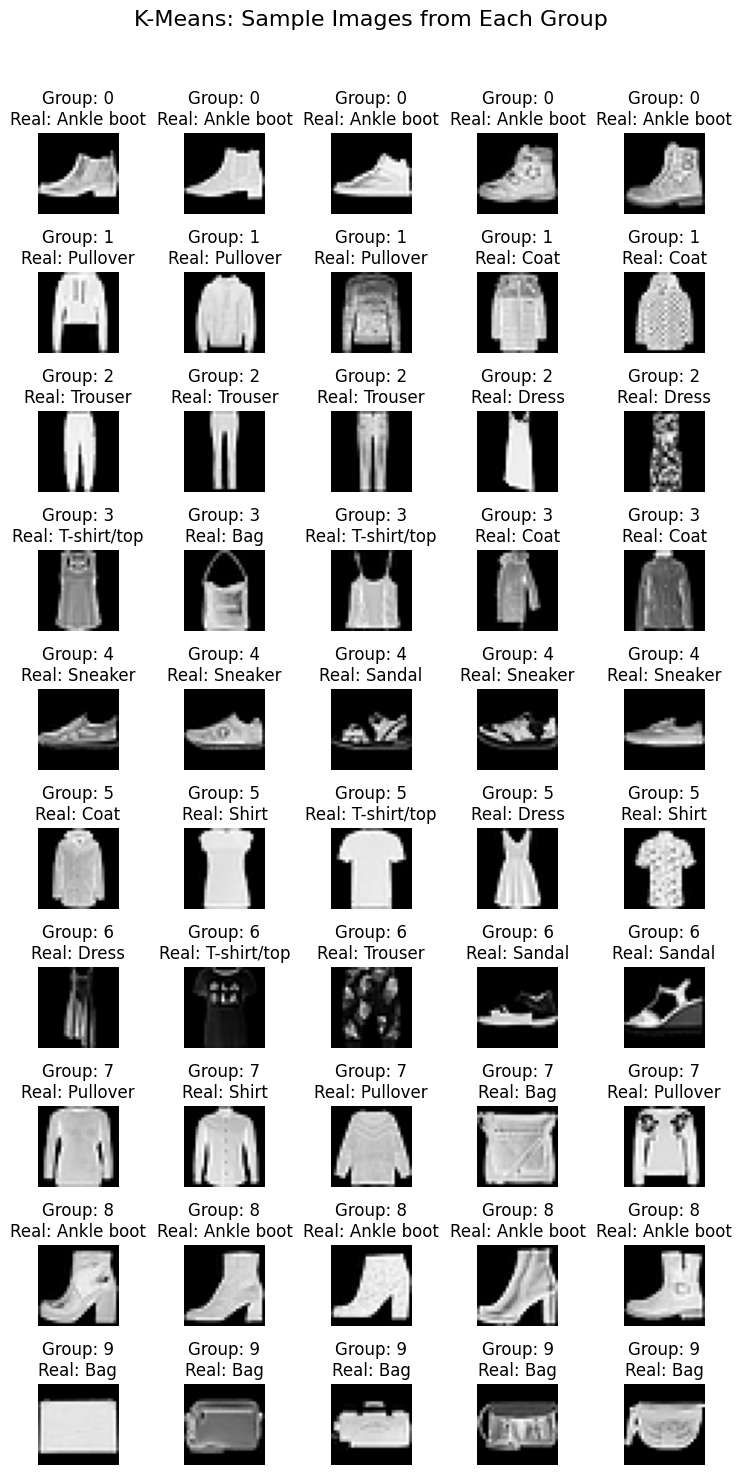

In [ ]:
plot_sample_images_from_clusters(X_subset, y_subset, kmeans_labels, n_clusters_kmeans, title_prefix="K-Means")

## **Checks if `agg_labels`, `X_hierarchical_original_scale`, and `y_hierarchical_subset` are not `None`. If valid, calls `plot_sample_images_from_clusters` to display up to 5 images per cluster for Agglomerative Clustering with "Agglomerative" title prefix and prints completion message. Otherwise, prints a message indicating clustering was skipped.**

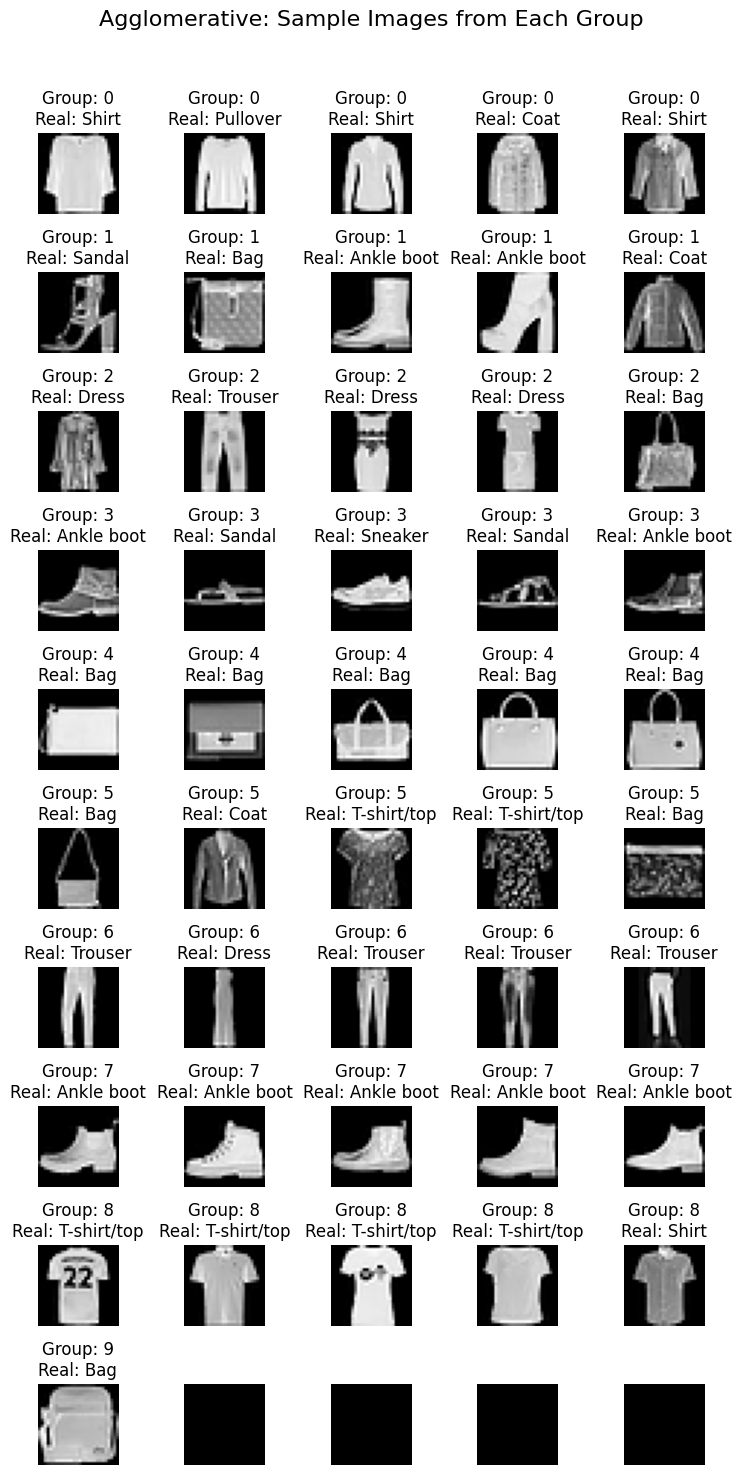

Display of sample images from Agglomerative Clustering clusters completed.


In [ ]:
if agg_labels is not None and X_hierarchical_original_scale is not None and y_hierarchical_subset is not None:

    plot_sample_images_from_clusters(X_hierarchical_original_scale, y_hierarchical_subset, agg_labels, n_clusters_agg, title_prefix="Agglomerative")
    print("Display of sample images from Agglomerative Clustering clusters completed.")
else:
    print("Display of sample images from Agglomerative Clustering clusters skipped due to clustering not being performed.")


## **Checks if `kmeans_labels` and `y_subset` exist, are not `None`, and have equal lengths. If valid, calculates and prints K-Means' Adjusted Rand Index (ARI) and V-measure. Otherwise, prints that K-Means results are unavailable. For Agglomerative Clustering, checks if `agg_labels` and `y_hierarchical_subset` are valid and equal in length, then calculates and prints ARI and V-measure. If not, prints that results are unavailable due to possible insufficient samples.**

In [ ]:
if 'kmeans_labels' in locals() and kmeans_labels is not None and 'y_subset' in locals() and y_subset is not None and len(y_subset) == len(kmeans_labels):
    kmeans_ari = adjusted_rand_score(y_subset, kmeans_labels)
    kmeans_vmeasure = v_measure_score(y_subset, kmeans_labels)
    print(f"  Adjusted Rand Index (ARI): {kmeans_ari:.4f}")
    print(f"  V-measure: {kmeans_vmeasure:.4f}")
else:
    print("  K-Means results are not available for calculating agreement metrics.")



print("\nAgglomerative Clustering Agreement Metrics:")

if 'agg_labels' in locals() and agg_labels is not None and \
   'y_hierarchical_subset' in locals() and y_hierarchical_subset is not None and \
   len(y_hierarchical_subset) == len(agg_labels):

    agg_ari = adjusted_rand_score(y_hierarchical_subset, agg_labels)
    agg_vmeasure = v_measure_score(y_hierarchical_subset, agg_labels)
    print(f"  Adjusted Rand Index (ARI): {agg_ari:.4f}")
    print(f"  V-measure: {agg_vmeasure:.4f}")
else:
    print("  Agglomerative Clustering results are not available for calculating agreement metrics (might not have run due to insufficient samples).")



  Adjusted Rand Index (ARI): 0.3374
  V-measure: 0.4913

Agglomerative Clustering Agreement Metrics:
  Adjusted Rand Index (ARI): 0.3488
  V-measure: 0.5466
